# Importiamo le librerie necessarie

In [1]:
# data manipulation
import pandas as pd

# numpy arrays
import numpy as np

# data visualization
import seaborn as sns

import matplotlib.pyplot as plt

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

sns.set()

# NLP
import string

from wordcloud import WordCloud

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from Code.NLTKVectorizer import NLTKVectorizer

import re

# machine learning
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes
from sklearn.svm import LinearSVC  # SVM
from sklearn.ensemble import RandomForestClassifier  # Random Forest

from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import mean_squared_error

# Model explainability
from lime.lime_text import LimeTextExplainer

# other
from pprint import pprint
from time import time
import logging
from functools import partial
import joblib

#nltk
import nltk

nltk.download('punkt')

nltk.download('stopwords')

nltk.download('wordnet')

en_stop_words = list(set(stopwords.words("english")))

# aggiungo a en_stop_words le parole dal file da noi creato
with open('stopwordsPersonali', 'r') as file:
    for line in file:
        en_stop_words.append(line.strip())


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lorus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lorus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lorus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Setup dati iniziali

 assegniamo i dataset di training e test alle variabili di train e test

In [12]:
dfTrain = pd.read_csv('Dataset/archive/train.csv')
dfTest = pd.read_csv('Dataset/archive/test.csv')

In [21]:
X_train = dfTrain['question_content']
y_train = dfTrain['topic']
X_test = dfTest['question_content']
y_test = dfTest['topic']

## Generatore della color palette

Questa funzione viene utilizata per creare una *palette* di `n` colori di `palette_name` colori.

In [2]:
def get_n_color_palette(palette_name, n_colors, as_hex=False):
    palette = sns.color_palette(palette=palette_name, n_colors=n_colors)
    if as_hex:
        palette = palette.as_hex()
    palette.reverse()
    return palette

## Plotly export chart 

Questa funzione è utilizzata per esportare l' HTML di plotly `fig_obj`, e salvarlo in: `assets/file_name.html`

In [3]:
def save_fig_as_div(fig_obj, file_name):
    with open(f"{file_name}", "w") as fig_file:
        fig_div_string = plotly.offline.plot(
            figure_or_data=fig_obj, output_type="div", include_plotlyjs="cdn"
        )
        fig_file.write(fig_div_string)

La funzione genera il report di classificazione per le previsioni del modello

## Funzione per il confusion matrix

Questa funzione genera una confusion map per le previsioni del modello

## Confusion Matrix

In [5]:
def get_confusion_matrix(y_true, y_pred, labels):

    # calcola la confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
    conf_matrix = np.flipud(conf_matrix)

    # crea una heatmap annotata della matrice di confusione
    fig = ff.create_annotated_heatmap(
        conf_matrix, x=labels.tolist(), y=labels.tolist()[::-1]
    )
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        title_text="<i><b>Confusion matrix</b></i>",
        xaxis_title="Predicted category",
        yaxis_title="Real category",
        plot_bgcolor="rgba(0, 0, 0, 0)",
        paper_bgcolor="rgba(0, 0, 0, 0)",
        font={
            "family": "Courier New, monospace",
            "size": 14,
            # 'color': "#eaeaea"
        },
    )
    fig.update_xaxes(tickangle=-45)
    fig["data"][0]["showscale"] = True

    return fig

# Data Statistics

Calcola per ogni topic nel dataset il numero dei topic

In [4]:
def get_classification_report(y_true, y_pred, target_names):

    # calcola il report di classificazione e lo converte in un DataFrame
    
    clf_report = classification_report(
        y_true=y_true, y_pred=y_pred, target_names=target_names, output_dict=True
    )
    clf_report_df = pd.DataFrame(data=clf_report)
    clf_report_df = clf_report_df.T
    clf_report_df.drop(columns=["support"], inplace=True)

    measures = clf_report_df.columns.tolist()
    classes = clf_report_df.index.tolist()

    # crea un heatmap annotato di plotly e aggiorna lo stile
    
    fig = ff.create_annotated_heatmap(clf_report_df.values, x=measures, y=classes)
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        title_text="<i><b>Classification report</b></i>",
        xaxis_title="Measures",
        yaxis_title="Class",
        plot_bgcolor="rgba(0, 0, 0, 0)",
        paper_bgcolor="rgba(0, 0, 0, 0)",
        font={
            "family": "Courier New, monospace",
            "size": 14,
            # 'color': "#eaeaea"
        },
    )
    fig.update_xaxes(tickangle=-45)
    fig["data"][0]["showscale"] = True

    return fig

In [6]:
categories_statistics_df = (
    dfTrain.groupby(by="topic")["id"]
    .agg(
        [
            ("count", lambda x: x.size),
        ]
    )
    .reset_index()
    .sort_values(by="count", ascending=False)
)

NameError: name 'dfTrain' is not defined

Calcola per ogni topic nel dataset la lunghezza media delle domande per topic

In [32]:
categories_statistics_df_questions = (
    dfTrain.groupby(by="topic")["question_content"]
    .agg(
        [
            ("mean", lambda x: x.str.len().mean()),
            ("max", lambda x: x.str.len().max()),
            ("min", lambda x: x.str.len().min()),
        ]
    )
    .reset_index()
)

## Categories article count:

Usa un grafico a torta per mostrare le percentuali di articoli per ogni topic:

In [11]:
blue_palette = get_n_color_palette("Blues", 20, True)

fig = px.pie(
    data_frame=categories_statistics_df,
    names="topic",
    values="count",
    color_discrete_sequence=blue_palette,
    title="Percentuale di domande per topic",
    width=800,
    height=500,
)

fig.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "font": {
            "family": "Courier New, monospace",
            "size": 14,
            # 'color': "#eaeaea"
        },
    }
)

fig.show()


Possiamo vedere che il dataset è *bilanciato*

In [18]:
# salvo il grafico in un file html
save_fig_as_div(fig, file_name='charts/categories-percentages-pie-chart.html')

## Lunghezza media delle domande per topic:

Usa un diagramma a barre per mostrare la lunghezza media delle domande per ogni topic:

In [20]:
chart_labels = {"mean": "Lunghezza delle domande", "Topic": "Topic type"}

fig = px.bar(
    data_frame=categories_statistics_df_questions.sort_values(by="mean"),
    x="topic",
    y="mean",
    color="mean",
    labels=chart_labels,
    title="Lunghezza media delle domande per topic",
    width=800,
    height=500,
)

fig.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "font": {
            "family": "Courier New, monospace",
            "size": 14,
            # 'color': "#eaeaea"
        },
    }
)

# rotate x-axis ticks
fig.update_xaxes(tickangle=-45)

fig.show()

Notiamo che la lunghezza delle domande è ben distrubuita per tutti i topic, tranne per il topic 0 (Society & Culture), 8 (Family & Relationships) e 9 (Politics & Government), che hanno una lunghezza media delle domande leggermente più lunga rispetto agli altri topic.

In [21]:
save_fig_as_div(fig, file_name="charts/average-article-length-bar-chart.html")

# Word Cloud

In [23]:
categories_text_df = dfTrain.groupby(by="topic").agg({"question_content": " ".join}).reset_index()

In [24]:
def plot_word_cloud(category_name, category_text):
    plt.subplots(figsize=(8, 8))
    wc = WordCloud(
        background_color="white", stopwords=en_stop_words, width=1000, height=600
    )
    wc.generate(category_text)
    plt.title(label=category_name)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.show()

La seguente word-cloud ci aiuterà a dare uno sguardo ai dati e al suo contenuto.

Per ogni word cloud, le parole con una frequenza maggiore hanno una dimensione maggiore.

Questo ci aiuterà a capire quali sono le parole più frequenti in ogni topic.

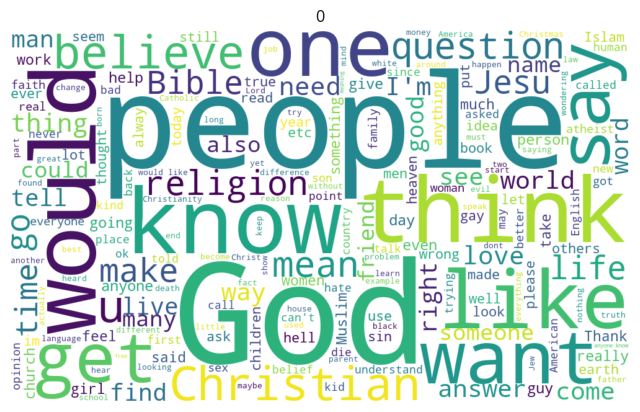

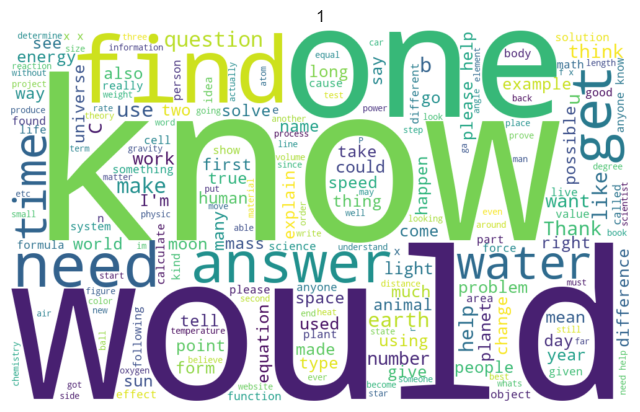

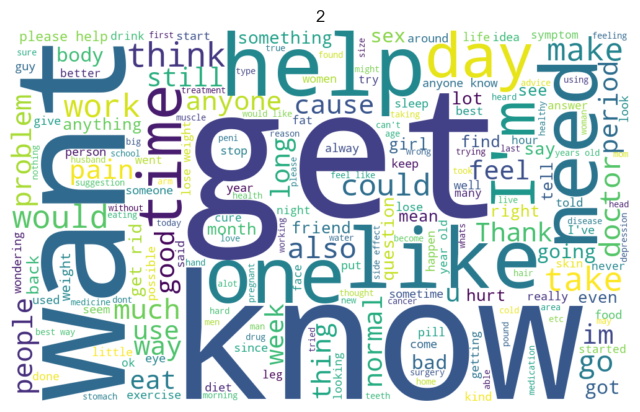

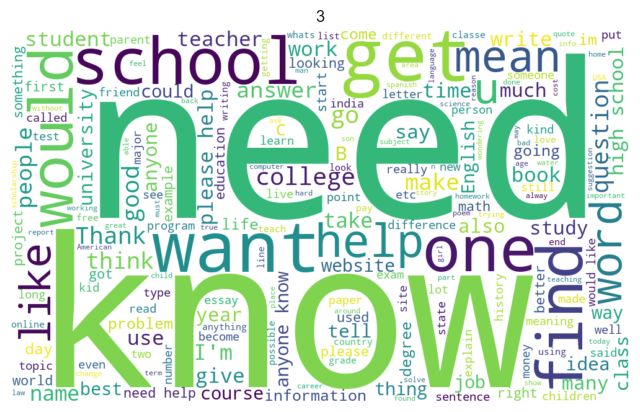

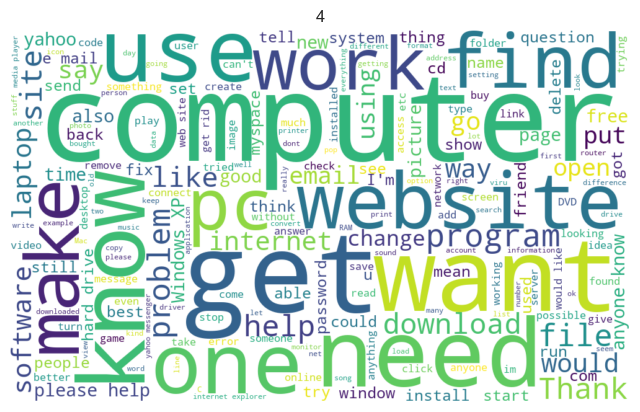

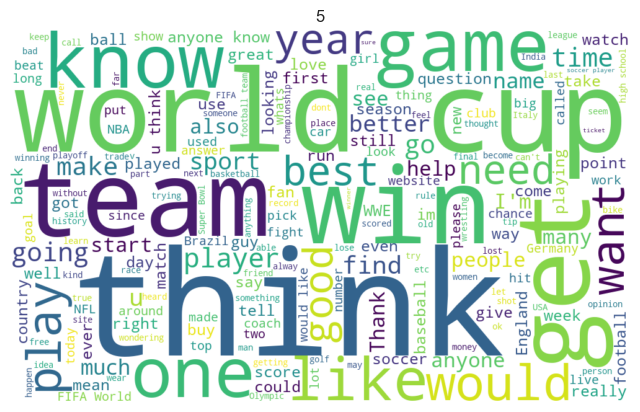

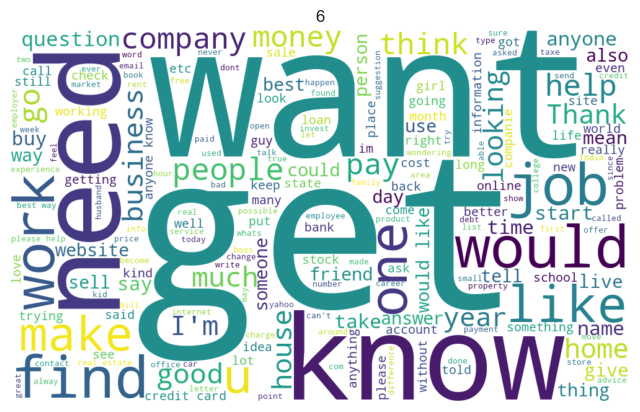

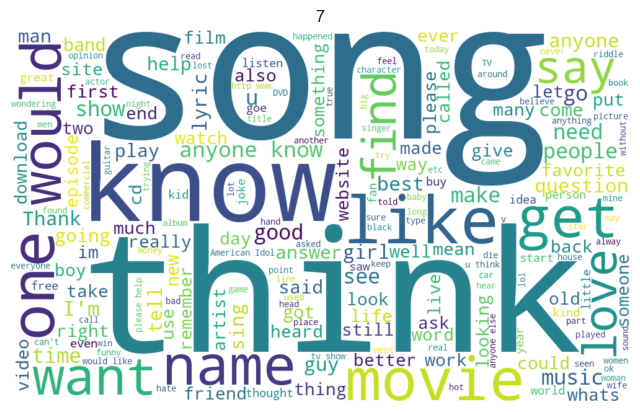

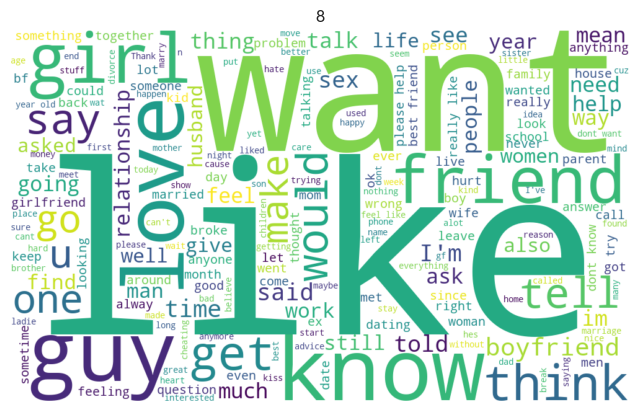

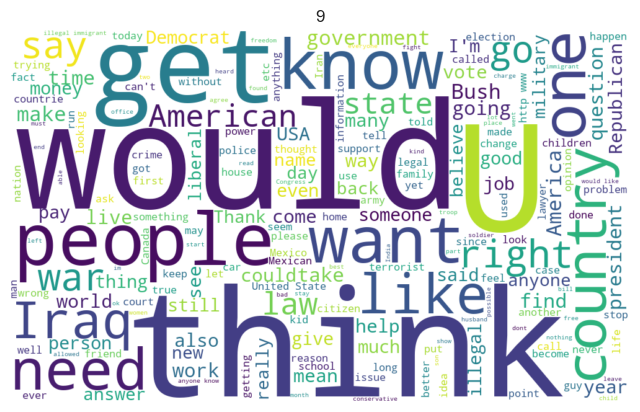

In [25]:
for idx, row in categories_text_df.iterrows():
    plot_word_cloud(row["topic"], row["question_content"])

Notiamo che le parole più comunemente usate, che però non rispecchiano il topic sono: 
- think
- would
- get
- want

Quindi sono state aggiunte alla lista di stopwords.

# Text Vectorization

In questo passaggio, costruiremo un **text vectorization** transformer che verrà utilizzato per convertire le domande grezze in funzionalità appropriate, preparate per essere inserite negli algoritmi di machine learning.

Definiamo un *custom vectorizer* chiamato `NLTKVectorizer`. Questo vectorizer eredita il `TfidfVectorizer` e sovrascrive il metodo `build_analyzer`. Il vectorizer risultante avrà gli stessi parametri del `TfidfVectorizer` ma analizzerà i documenti in modo diverso, principalmente utilizzerà il tokenzier `NLTK`, lemmatizer.

## Vectorizer e tipi di modelli

Qui di seguito viene definito il vectorizer e i modelli che verranno presi in considerazione

In [61]:
# text vectorizer
vectorizer = NLTKVectorizer(
    stop_words=en_stop_words, max_df=0.5, min_df=10, max_features=10000
)

# Logistic Regression classifier
lr_clf = LogisticRegression(C=1.0, solver="newton-cg", multi_class="multinomial", n_jobs=1, verbose=2)

# Naive Bayes classifier
nb_clf = MultinomialNB(alpha=0.01)

# SVM classifier
svm_clf = LinearSVC(C=1.0, verbose=2)

# Random Forest classifier
random_forest_clf = RandomForestClassifier(
    n_estimators=100, criterion="gini", max_depth=50, random_state=0, n_jobs=1, verbose=2)



In [62]:
# create pipeline object
pipeline = Pipeline([("vect", vectorizer), ("clf", lr_clf)])
#pipeline = Pipeline([("vect", vectorizer), ("clf", svm_clf)])
#pipeline = Pipeline([("vect", vectorizer), ("clf", random_forest_clf)])


In [46]:
# mean squared error

models = [lr_clf, nb_clf, svm_clf, random_forest_clf]
dict = {}
for model in models:
    pipeline = Pipeline([("vect", vectorizer), ("clf", model)])
    pipeline = pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(pipeline)
    dict[model] = mean_squared_error(y_test, y_pred)
print(sorted(dict.items(), key=lambda x: x[1]))


KeyboardInterrupt: 

## Risultati:
[(LinearSVC(verbose=2), 6.253166666666667), (LogisticRegression(multi_class='multinomial', n_jobs=2, solver='newton-cg',
                   verbose=2), 6.3049), (MultinomialNB(alpha=0.01), 6.743266666666667), (RandomForestClassifier(max_depth=50, n_jobs=2, random_state=0, verbose=2), 10.1255)]
                
Il modello migliore da utilizzare è il LinearSVC

# Creazione della pipeline

Creo la pipeline con il modello migliore e il vectorizer a cui passo le stopwords

In [31]:
%%time
pipeline.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


CPU times: total: 6min 7s
Wall time: 9min 37s


Pipeline(steps=[('vect',
                 NLTKVectorizer(max_df=0.5, max_features=10000, min_df=10,
                                stop_words=['above', 'have', 'more', 'into',
                                            'were', 'an', 'their', 'he', 'what',
                                            'being', 'while', 'her', 'here',
                                            'to', 'of', 'mustn', 'isn', 'for',
                                            'themselves', 'after', 'y',
                                            'yourselves', 'about', 'further',
                                            'all', 'same', 'each', "didn't",
                                            'a', 'below', ...])),
                ('clf',
                 LogisticRegression(multi_class='multinomial', n_jobs=8,
                                    solver='newton-cg', verbose=2))])

In [56]:
%%time
y_pred = pipeline.predict(X_test)
#y_pred = model.predict(X_test)


CPU times: total: 16.9 s
Wall time: 22.4 s


## Classification report:

In [58]:
target_names = [0, 1, 2, 3 ,4 ,5 ,6, 7, 8 ,9]
target_names=list(map(str,target_names))
classes = target_names
fig = get_classification_report(
    y_true=y_test, y_pred=y_pred, target_names=classes
)
fig.show()

In [37]:
save_fig_as_div(fig_obj=fig, file_name="charts/classification-report_svc.html")

## Confusion matrix:

In [59]:
fig = get_confusion_matrix(y_true=y_test, y_pred=y_pred, labels=pipeline.classes_)
fig.show()

In [60]:
save_fig_as_div(fig_obj=fig, file_name="charts/confusion-matrix_lr.html")

In [ ]:
parameters = {
    # vectorizer hyper-parameters
    #'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__ngram_range': [(1, 1)],
    #'vect__max_df': [0.4, 0.5, 0.6],
    'vect__max_df': [0.5],
    #'vect__min_df': [10, 50, 100],
    'vect__min_df': [10],
    #'vect__max_features': [5000, 10000],
    'vect__max_features': [10000],
    # classifiers
    'clf': [lr_clf, nb_clf, svm_clf, random_forest_clf]
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=12)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

In [33]:
from joblib import dump, load

In [0]:
dump(pipeline, 'dump/model_lr.joblib')

In [24]:
pipeline = load('dump/model_svc.joblib')

# Model Explainability (OPTIONAL)

## Visualizing classifier weights:

In [40]:
feature_names = pipeline["vect"].get_feature_names()

AttributeError: 'NLTKVectorizer' object has no attribute 'get_feature_names'

In [ ]:
clf = pipeline.named_steps["clf"]

In [ ]:
coefs_values = sum(
    [classifier.base_estimator.coef_ for classifier in clf.calibrated_classifiers_]
)

coefs_values = coefs_values / len(clf.calibrated_classifiers_)

In [ ]:
classes = clf.classes_

In [ ]:
n_feature = 15

In [ ]:
for i, class_label in enumerate(classes):

    # get indices of top positive/negative coefficient
    negative_coefs_indices = np.argsort(coefs_values[i])[:n_feature]
    positive_coefs_indices = np.argsort(coefs_values[i])[-n_feature:]

    # get the coefficient values
    negative_coefs = [coefs_values[i][coef_idx] for coef_idx in negative_coefs_indices]
    positive_coefs = [coefs_values[i][coef_idx] for coef_idx in positive_coefs_indices]

    # get the corresponding features names of the top coefficient
    negative_features = [feature_names[coef_idx] for coef_idx in negative_coefs_indices]
    positive_features = [feature_names[coef_idx] for coef_idx in positive_coefs_indices]

    # stack arrays into one array
    weights = np.concatenate([negative_coefs, positive_coefs])
    features = np.concatenate([negative_features, positive_features])

    # plot feature names agains their weight, using bar plot
    chart_title = f"{class_label} articles"

    chart_labels = {"x": "Feature name", "y": "Feature weight"}

    fig = px.bar(
        x=features,
        y=weights,
        color=weights,
        title=chart_title,
        orientation="v",
        labels=chart_labels,
        width=800,
        height=500,
        color_continuous_scale=["red", "blue"],
    )

    # rotate x-axis ticks
    fig.update_xaxes(tickangle=45)

    fig.update_layout(
        {
            "plot_bgcolor": "rgba(0, 0, 0, 0)",
            "paper_bgcolor": "rgba(0, 0, 0, 0)",
            "font": {
                "family": "Courier New, monospace",
                "size": 14,
                # 'color': "#eaeaea"
            },
        }
    )

    fig.show()



In [ ]:
    save_fig_as_div(
        fig, file_name=f"model-coefficients/{class_label}-class-bar-chart.html"
    )

## Explaining individual predictions:

In [41]:
clf_predictions_df = pd.DataFrame(
    data={
        "text": X_test.values,
        "real category": y_test.values,
        "predicted category": y_pred,
    }
)

clf_predictions_df["text length"] = clf_predictions_df["text"].str.len()

clf_predictions_df.sort_values(by="text length", ascending=False, inplace=True)

In [42]:
clf_predictions_df.head()

text  real category  \
47774  Is this ok for a personal statement? I'm in ye...              3   
30377  What do you think of this joke? read on! You w...              7   
16752  from the  washington times maybe we should ado...              9   
58108  Love one another as I love you. Only then, wil...              0   
52192  CALLING ALL HANDICAPPERS...The Belmont Stakes-...              5   

       predicted category  text length  
47774                   3         4001  
30377                   2         3972  
16752                   9         3971  
58108                   0         3962  
52192                   5         3924

In [43]:
# samples which has been correctly classified
correct_classified_df = clf_predictions_df[
    clf_predictions_df["real category"] == clf_predictions_df["predicted category"]
]

In [44]:
# samples which has been incorrectly classified
incorrect_classified_df = clf_predictions_df[
    clf_predictions_df["real category"] != clf_predictions_df["predicted category"]
]

In [45]:
# preprocessing function used in the pipeline to analyze input documents
tokenize_fn = pipeline.named_steps["vect"].build_analyzer()

In [46]:
explainer = LimeTextExplainer(verbose=True, class_names=pipeline.classes_)

In [47]:
clf_fn = pipeline.predict_proba

### When the model is performing well

In [ ]:
correct_sample = correct_classified_df.loc[[2573]]

In [ ]:
correct_sample

In [ ]:
text_to_explain = correct_sample["text"].values[0]
cleaned_text_to_explain = " ".join(tokenize_fn(text_to_explain))

In [ ]:
exp_object = explainer.explain_instance(
    text_instance=cleaned_text_to_explain,
    classifier_fn=clf_fn,
    top_labels=2,
    num_features=10,
    num_samples=10000,
)

In [ ]:
labels = exp_object.available_labels()

In [ ]:
exp_object.show_in_notebook(labels=labels)

In [ ]:
exp_object.save_to_file(
    file_path="assets/model-explanations/correct-classification-explanation.html",
    labels=labels,
)

Here the classifier predicted the correct class of the sample

In [ ]:
# politics_mideast class
exp_object.as_list(label=10)

We can see that words like `omar` and `hand` are negative fearues for this class, and if we remove them from the document, the the prediction percentage of class `politics_mideast` would increase.

In [ ]:
cleaned_text_to_explain = re.sub("omar|hand", "", cleaned_text_to_explain)

In [ ]:
exp_object = explainer.explain_instance(
    text_instance=cleaned_text_to_explain,
    classifier_fn=clf_fn,
    top_labels=2,
    num_features=10,
    num_samples=10000,
)

In [ ]:
labels = exp_object.available_labels()

In [ ]:
exp_object.show_in_notebook(labels=labels)

### When the model is performing badly:

In [49]:
incorrect_sample = incorrect_classified_df.loc[[30377]]

In [ ]:
incorrect_sample

In [50]:
text_to_explain = incorrect_sample["text"].values[0]
cleaned_text_to_explain = " ".join(tokenize_fn(text_to_explain))

In [51]:
exp_object = explainer.explain_instance(
    text_instance=cleaned_text_to_explain,
    classifier_fn=clf_fn,
    top_labels=2,
    num_features=10,
    num_samples=10000,
)

Intercept 0.13879893868956494
Prediction_local [0.21291589]
Right: 0.20446503214686992
Intercept 0.1480659780869055
Prediction_local [0.37129576]
Right: 0.3574309904813589


In [52]:
labels = exp_object.available_labels()

In [53]:
exp_object.show_in_notebook(labels=labels)

Here the classifier predicted an incorrect class, it predicted the class `autos` while the correct class is `forsale`, the reason is that the document very short, it contains two words about selling, and two words about cars, and the classification probabilities for the two classes were almost equal, let's try another example:

In [ ]:
incorrect_sample = incorrect_classified_df.loc[[4251]]

In [ ]:
incorrect_sample

Here, the classifier had done the opposite of the previous case, it predicted the class `forsale` while the real class is `autos`.

In [ ]:
text_to_explain = incorrect_sample["text"].values[0]
cleaned_text_to_explain = " ".join(tokenize_fn(text_to_explain))

In [ ]:
exp_object = explainer.explain_instance(
    text_instance=cleaned_text_to_explain,
    classifier_fn=clf_fn,
    top_labels=2,
    num_features=10,
    num_samples=10000,
)

In [ ]:
labels = exp_object.available_labels()

In [ ]:
exp_object.show_in_notebook(labels=labels)

What happened here is that the classifier had correlated words like `seat` and `owner` with class `autos`, and words like `sale`, `original` and `sell` with class `forsale`, we can inspect the sample more to understand why it's so confusing:

In [ ]:
print(text_to_explain)

Reading through the article, I *myself* actually got confused! so the article goes about someone criticizing the idea of posting car-seats ads, and he mentions two car models, the [Toyota MR2](https://en.wikipedia.org/wiki/Toyota_MR2) and the [Toyota Celica](https://en.wikipedia.org/wiki/Toyota_Celica), these two words are very informative to recognize the `autos` class, but it's hard for the classifier to catch them (since it's based on frequency statistics).

In [ ]:
exp_object.save_to_file(
    file_path="assets/model-explanations/incorrect-classification-explanation.html",
    labels=labels,
)

# Improving accuracy

## Edit normalization

After inspecting how the model is predicting classes, we saw that word `MR2` is actually relevant to the classification, but it's being removed by the analyzer, I'll change the value of `min_token_length` to 2, this way only tokens of two letters or less will be removed.

In [ ]:
vectorizer = NLTKVectorizer(
    max_df=0.5,
    min_df=10,
    ngram_range=(1, 1),
    max_features=10000,
    stop_words=en_stop_words,
    min_token_length=2,
)

svm_clf = LinearSVC(C=1.0)

In [ ]:
clf = CalibratedClassifierCV(base_estimator=svm_clf, cv=5, method="isotonic")

In [ ]:
pipeline = Pipeline([("vect", vectorizer), ("clf", clf)])

In [22]:
%%time
pipeline.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
%%time
y_pred = pipeline.predict(X_test)

## Classification report

In [ ]:
save_fig_as_div(fig_obj=fig, file_name="charts/classification-report-improved.html")

## Confusion matrix

In [5]:
fig = get_confusion_matrix(y_true=y_test, y_pred=y_pred, labels=pipeline.classes_)
fig.show()

NameError: name 'y_test' is not defined

In [ ]:
save_fig_as_div(fig_obj=fig, file_name="charts/confusion-matrix-improved.html")

## AI model Dump

Creiamo il dump del modello

## Carichiamo il modello e utilizziamolo per fare delle previsioni

In [18]:
text = input('Enter your question: ')

predictProba = pipeline.predict_proba([text])

array = ["Society & culture", "Science & Mathematics", "Health", "Education & Reference", "Computers & Internet", "Sports", "Business & Finance", "Entertainment & Music", "Family & Relationships", "Politics & Government"]
stat = predictProba[0][pipeline.predict([text])[0]] * 100

print("\"" + text + "\"" + "\n" " is about: " + "\"" + array[pipeline.predict([text])[0]]+ "\"" +"\n"+" with a probability of " +"%.3f" %stat + "%" "\n")

for i in range(10):
    print("\t\t\t"+ array[i] + " : " + "%.3f" % (predictProba[0][i] * 100) + "%")

"Scattered around a huge crater are the remnants of a life that is gone. Random pieces of clothing and a red makeup bag lie in the mud. Nearby, an English language textbook, bits of broken furniture and a pillow with floral embroidery are jumbled together in one large pile.  The crater sits right in the middle of a residential neighborhood in central Khan Younis, the besieged city in southern Gaza that is the current epicenter of the war between Israel and Hamas.  The city is the hometown of Hamas’ leader in Gaza, Yahya Sinwar, and, according to the Israel Defense Forces (IDF), a major Hamas stronghold. It’s also an area to which the Israeli military urged large numbers of civilians to flee in the early days of the war, when northern Gaza was the focus of Israel’s operations.  Looking around, it’s clear that the IDF went into Khan Younis with full force.  According to the IDF, the crater is all that is left of a building similar to the others in the area. The military said it was flatt